In [193]:
library(readxl)
library(stringr)

In [349]:
# get variant info
variant_info = read.csv('../raw_data/ROSMAP_WGS/HIGHandMED_coding_annotations_syn11724057_subset.csv', check.names=FALSE)

keep = c('splice_region_variant&intron_variant',
       'missense_variant&splice_region_variant',
       'splice_region_variant',
       'frameshift_variant', 
       'splice_acceptor_variant&intron_variant',
       'stop_gained',
       '5_prime_UTR_premature_start_codon_gain_variant',
       'splice_donor_variant&intron_variant',
       'frameshift_variant&splice_region_variant', 'missense_variant') # keep potentially high-impact variants

variant_subset = variant_info[variant_info$EFFECT%in%keep,]

genes = c('SORL1', 'TREM2', 'ABCA7', 'ATP8B4', 'ABCA1', 'ADAM10')
variant_subset = variant_subset[variant_subset$GENE%in%genes,]
variant_subset = variant_subset[variant_subset$FILTER_PASS=='True',]

In [350]:
# split info and genotypes
colnames = c('CHROM',
 'POS',
 'REF_x',
 'ALT_0',
 'ALT_1',
 'ALT_2',
 'ID',
 'REF_y',
 'ALT',
 'EFFECT',
 'IMPACT',
 'GENE',
 'GENEID',
 'HGVS_C',
 'HGVC_P',
 'LOF',
 'NMD',
 'MAF')

colnames2 = c('CHROM',
 'POS',
 'REF_x',
 'ALT_0',
 'ALT_1',
 'ALT_2',
 'FILTER_PASS',
 'numalt',
 'AF_0',
 'AF_1',
 'AF_2',
 'ID',
 'REF_y',
 'ALT',
 'EFFECT',
 'IMPACT',
 'GENE',
 'GENEID',
 'HGVS_C',
 'HGVC_P',
 'LOF',
 'NMD',
 '1000Gp3_AF',
 'N -1/-1',
 'N 0/0',
 'N 0/1',
 'N 0/2',
 'N 0/3',
 'N 0/4',
 'N 0/5',
 'N 0/6',
 'N 1/1',
 'N 1/2',
 'N 1/3',
 'N 1/4',
 'N 1/5',
 'N 1/6',
 'N 2/2',
 'N 2/3',
 'N 2/4',
 'N 2/5',
 'N 2/6',
 'N 3/3',
 'N 3/4',
 'N 3/5',
 'N 3/6',
 'N 4/4',
 'N 4/5',
 'N 4/6',
 'N 5/5',
 'N 5/6',
 'N 6/6',
 'MAF', '')

info = variant_subset[,colnames]
vars = variant_subset[,!colnames(variant_subset)%in%colnames2]

In [351]:
# load the variant info and WGS to projid mapping
dictionary = read.csv('../processed_data/variants/projid_wgsid_dict.csv', row.names=1)
# vars = read.csv('../processed_data/variants/variant_subset_geno.csv', row.names=1)
# info = read.csv('../processed_data/variants/variant_subset_info.csv', row.names=1)

# load the full metadata
full_metadata = read_excel('../raw_data/metadata/dataset_1282_basic_06-16-2023.xlsx')
full_metadata = as.data.frame(full_metadata[, c('projid', 'study', 'pmi', 'age_death', 'msex', 'amyloid',  'ceradsc',  'nft', 'braaksc', 'cogdx', 'niareagansc', 'ad_reagan', 'apoe_genotype')])
rownames(full_metadata) = full_metadata$projid

In [352]:
# merge metadata with WGSids
dictionary$WGSid = dictionary$X0#unlist(lapply(dictionary$X0, function(x) str_replace(x, '-', '.')))
meta = merge(dictionary, full_metadata, by = 0)

# subset variants by WGSids                                 
vars_subset = vars[,meta$WGSid]

# subset by high impact or ABCA7                               
index = info$IMPACT=='HIGH' | info$GENE=='ABCA7'
info_subset = info[index,]
vars_subset = t(vars_subset[index,])                                 
colnames(vars_subset) = info_subset$POS
vars_subset = as.data.frame(vars_subset)
                                 
# add LOF burden as annotation cols to vars_subset
index2 = info$LOF!="" | info$HGVS_C=='c.5570+5G>C'
                                 
lof_list =  split(as.character(info[index2,'POS']), info[index2,'GENE'])

for( name in names(lof_list)){
    
    if(length(lof_list[[name]])>1){
        vars_subset[,name] = ifelse(rowSums(vars_subset[,lof_list[[name]]]!='0/0')>0, 1, 0)
    }else{
        vars_subset[[name]] = ifelse(vars_subset[,lof_list[[name]]]!='0/0', 1, 0)
    }
}

# combine metadata with genotypes                                 
all_meta = cbind(meta, vars_subset)
rownames(all_meta) = all_meta$projid
all_info = info_subset

In [353]:
sn_data = read.csv('../processed_data/variants/ROSMAP_snRNAseq_PFC_individual_human.csv')
projid_mapping = read.csv('../raw_data/metadata/ROSMAP_clinical.csv')

rownames(projid_mapping) = projid_mapping$individualID

sn_data$projid = projid_mapping[sn_data$individualID,'projid']

In [355]:
temp = all_meta[rownames(all_meta)%in%sn_data$projid,]

In [ ]:
# test KL clusters for different LOF samples

# test KL clusters for rs3752246, while controling for _ _

# test KL clusters for rs7.., while controling for

In [367]:
table(temp[,as.character(all_info[all_info$ID=='rs3752246',]$POS)])


0/0 0/1 1/1 
 17 120 247 

In [372]:
as.character(all_info[all_info$ID=='rs3752246',]$POS)

[1] "1056492"

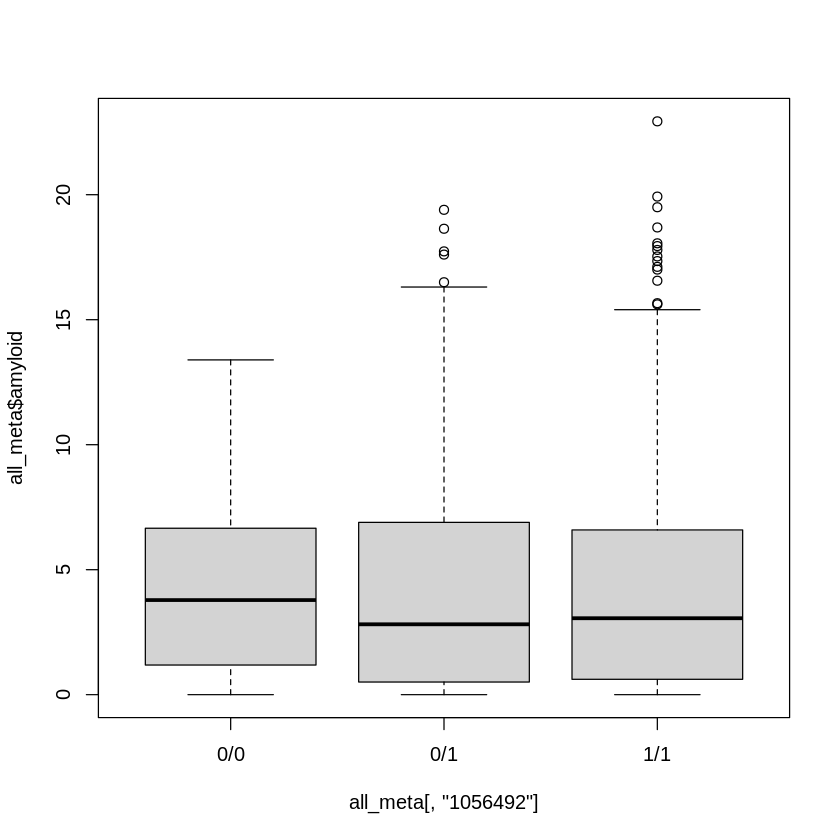

In [377]:
boxplot(all_meta$amyloid~all_meta[,'1056492'])

In [362]:
all_meta

,Row.names,X0,WGSid,projid,study,pmi,age_death,msex,amyloid,ceradsc,⋯,1065304,1065305,1065410,41126715,41129078,107594912,ABCA1,ABCA7,ATP8B4,TREM2
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10100574,10100574,SM-CJFOS,SM-CJFOS,10100574,ROS,22.250000,83.53730,1,0.7943750,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10100862,10100862,SM-CTDVD,SM-CTDVD,10100862,ROS,10.733333,84.21629,1,1.2912500,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101039,10101039,SM-CJJ1G,SM-CJJ1G,10101039,ROS,14.166667,92.29843,1,7.4815625,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101291,10101291,SM-CTEF8,SM-CTEF8,10101291,ROS,7.583333,83.39767,1,0.0000000,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101327,10101327,SM-CJGI5,SM-CJGI5,10101327,ROS,13.250000,89.71389,1,3.7008333,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101589,10101589,SM-CJEIA,SM-CJEIA,10101589,ROS,9.916667,108.28200,1,1.1156250,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10102206,10102206,SM-CTEEK,SM-CTEEK,10102206,ROS,22.333333,80.18070,1,0.0000000,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10202345,10202345,SM-CJEI6,SM-CJEI6,10202345,ROS,6.750000,81.57974,1,3.1383333,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10203224,10203224,SM-CJGGM,SM-CJGGM,10203224,ROS,7.250000,83.25257,1,1.7659375,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0


In [287]:
y = temp[temp$ABCA7==1,]
x = read.csv('../raw_data/metadata/single_cell_individual_metadata.csv')$projid

In [288]:
y$projid%in%x

[1] FALSE  TRUE FALSE FALSE

In [ ]:
# snRNAseq w WGS has 3 LoF individuals not in our study (some validation with those like with the proteomics data?)

In [293]:
all_info$POS[all_info$ID=='rs3752246']

integer(0)

In [303]:
variant_info = read.csv('../raw_data/ROSMAP_WGS/HIGHandMED_coding_annotations_syn11724057_subset.csv')


In [310]:
variant_info[variant_info$ID=='rs3752246',][,1:20]

,X,CHROM,POS,REF_x,ALT_0,ALT_1,ALT_2,FILTER_PASS,numalt,AF_0,AF_1,AF_2,ID,REF_y,ALT,EFFECT,IMPACT,GENE,GENEID,HGVS_C
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
11414,11413,19,1056492,G,C,,,True,1,0.815,NA,NA,rs3752246,G,C,missense_variant,MODERATE,ABCA7,ENSG00000064687,c.4580G>C


In [300]:
info[info$ID=='rs3752246',]

CHROM,POS,REF_x,ALT_0,ALT_1,ALT_2,ID,REF_y,ALT,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVC_P,LOF,NMD,MAF
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>


In [301]:
info

,CHROM,POS,REF_x,ALT_0,ALT_1,ALT_2,ID,REF_y,ALT,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVC_P,LOF,NMD,MAF
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
420,11,121348824,C,G,,,rs778896351,C,G,splice_region_variant&intron_variant,LOW,SORL1,ENSG00000137642,c.403-3C>G,,,,0.0004180602
423,11,121348951,G,A,,,rs750601899,G,A,missense_variant&splice_region_variant,MODERATE,SORL1,ENSG00000137642,c.527G>A,p.Arg176Gln,,,0.0004180602
688,11,121367557,CT,C,CTT,,rs199875238,CT,C,splice_region_variant&intron_variant,LOW,SORL1,ENSG00000137642,c.759-8delT,,,,0.0367892977
689,11,121367557,CT,C,CTT,,rs112421669,C,CT,splice_region_variant&intron_variant,LOW,SORL1,ENSG00000137642,c.759-8dupT,,,,0.0367892977
971,11,121391367,T,C,,,.,T,C,missense_variant&splice_region_variant,MODERATE,SORL1,ENSG00000137642,c.1213T>C,p.Tyr405His,,,0.0004180602
996,11,121393703,G,A,,,.,G,A,splice_region_variant&intron_variant,LOW,SORL1,ENSG00000137642,c.1596+5G>A,,,,0.0004180602
1917,11,121458731,C,T,,,rs377292128,C,T,missense_variant&splice_region_variant,MODERATE,SORL1,ENSG00000137642,c.3817C>T,p.Pro1273Ser,,,0.0004180602
2290,11,121491758,C,CT,,,rs770651839,C,CT,splice_region_variant&intron_variant,LOW,SORL1,ENSG00000137642,c.5890-9dupT,,,,0.0025083612
2304,11,121492985,C,T,,,rs372726960,C,T,splice_region_variant&intron_variant,LOW,SORL1,ENSG00000137642,c.6171+8C>T,,,,0.0004180602


In [289]:
temp

,Row.names,X0,WGSid,projid,study,pmi,age_death,msex,amyloid,ceradsc,⋯,1061892,1062164,1064152,41126715,41129078,107594912,ABCA1,ABCA7,ATP8B4,TREM2
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10100574,10100574,SM-CJFOS,SM.CJFOS,10100574,ROS,22.250000,83.53730,1,0.7943750,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10100862,10100862,SM-CTDVD,SM.CTDVD,10100862,ROS,10.733333,84.21629,1,1.2912500,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101291,10101291,SM-CTEF8,SM.CTEF8,10101291,ROS,7.583333,83.39767,1,0.0000000,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101327,10101327,SM-CJGI5,SM.CJGI5,10101327,ROS,13.250000,89.71389,1,3.7008333,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10101589,10101589,SM-CJEIA,SM.CJEIA,10101589,ROS,9.916667,108.28200,1,1.1156250,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10102206,10102206,SM-CTEEK,SM.CTEEK,10102206,ROS,22.333333,80.18070,1,0.0000000,4,⋯,0/0,1/1,0/0,0/0,0/0,0/0,0,0,0,0
10202345,10202345,SM-CJEI6,SM.CJEI6,10202345,ROS,6.750000,81.57974,1,3.1383333,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10203224,10203224,SM-CJGGM,SM.CJGGM,10203224,ROS,7.250000,83.25257,1,1.7659375,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
10205244,10205244,SM-CJIXD,SM.CJIXD,10205244,ROS,15.616667,82.96509,1,1.3525000,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0


In [245]:
all_meta

,Row.names,X0,WGSid,projid,study,pmi,age_death,msex,amyloid,ceradsc,⋯,1061892,1062164,1064152,41126715,41129078,107594912,ABCA1,ABCA7,ATP8B4,TREM2
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SM.CJFOS,10100574,SM-CJFOS,SM.CJFOS,10100574,ROS,22.250000,83.53730,1,0.7943750,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CTDVD,10100862,SM-CTDVD,SM.CTDVD,10100862,ROS,10.733333,84.21629,1,1.2912500,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CJJ1G,10101039,SM-CJJ1G,SM.CJJ1G,10101039,ROS,14.166667,92.29843,1,7.4815625,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CTEF8,10101291,SM-CTEF8,SM.CTEF8,10101291,ROS,7.583333,83.39767,1,0.0000000,4,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CJGI5,10101327,SM-CJGI5,SM.CJGI5,10101327,ROS,13.250000,89.71389,1,3.7008333,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CJEIA,10101589,SM-CJEIA,SM.CJEIA,10101589,ROS,9.916667,108.28200,1,1.1156250,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CTEEK,10102206,SM-CTEEK,SM.CTEEK,10102206,ROS,22.333333,80.18070,1,0.0000000,4,⋯,0/0,1/1,0/0,0/0,0/0,0/0,0,0,0,0
SM.CJEI6,10202345,SM-CJEI6,SM.CJEI6,10202345,ROS,6.750000,81.57974,1,3.1383333,1,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0
SM.CJGGM,10203224,SM-CJGGM,SM.CJGGM,10203224,ROS,7.250000,83.25257,1,1.7659375,2,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0,0,0,0


In [236]:
sn_data

individualID,individualIdSource,species,sex,race,ethnicity,yearsEducation,ageDeath,causeDeath,mannerDeath,apoeGenotype,pmi,pH,brainWeight,diagnosis,diagnosisCriteria,CERAD,Braak
<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
R2626559,Rush,Human,male,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R9936070,Rush,Human,male,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R2367199,Rush,Human,male,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R9891381,Rush,Human,female,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R9033345,Rush,Human,male,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R2901804,Rush,Human,male,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R2264515,Rush,Human,female,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R5629689,Rush,Human,female,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
R1687970,Rush,Human,male,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [231]:
full_metadata = read_excel('../raw_data/metadata/dataset_1282_basic_06-16-2023.xlsx')

colnames(full_metadata)

[1] "projid"             "study"              "scaled_to"         
 [4] "apoe_genotype"      "age_first_ad_dx"    "cogdx"             
 [7] "cognep_demog_slope" "cogng_demog_slope"  "cognpo_demog_slope"
[10] "cognps_demog_slope" "cognse_demog_slope" "cognwo_demog_slope"
[13] "age_bl"             "age_death"          "msex"              
[16] "ad_reagan"          "braaksc"            "ceradsc"           
[19] "gpath"              "niareagansc"        "pmi"               
[22] "amyloid"            "plaq_d"             "plaq_n"            
[25] "hip_scl_3reg_yn"    "dlbdx"              "lb_7reg"           
[28] "nft"                "tangles"            "tdp_st4"           
[31] "arteriol_scler"     "caa_4gp"            "cvda_4gp2"         
[34] "ci_num2_gct"        "ci_num2_mct"        "ci_num2_tct"